<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import glob
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
os.path.isfile('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918')
import sys
import time
import cv2
try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.components_evaluation import estimate_components_quality_auto
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

### Setup some parameters

In [2]:
# dataset dependent parameters
fname = ['/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G.tiff',
         '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T8_G.tiff'
         ]  

# filename to be processed
fr = 4                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (6, 6)         # maximum allow rigid shift
splits_rig = 2          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 2         # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = False        # flag for analyzing dendritic data
alpha_snmf = None           # sparsity penalty for dendritic data analysis through sparse NMF

# parameters for component evaluation
min_SNR = 2.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
cnn_thr = 0.8               # threshold for CNN based classifier

Download the dataset if not already present

In [3]:
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovie.tif']:
    fname = [download_demo(fname[0])]

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [4]:
m_orig = cm.load_movie_chain(fname[:2])
downsample_ratio = 0.2
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=10, offset=offset_mov, fr=4, magnification=2)

100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


reshaping along z


##### Setup a cluster

In [5]:
#%% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


10
10
10
10
10
10


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


20


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


20


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


20
20
20
20
30
30
30
30
30
40
30
40
40
50
40
50
40
40
50
0


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


50
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0
10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
40
40
40
30
40
50
50
50
40
40
0
50
50
50
10
20
30
40
50
0
0
10
10
20
20
30
30
40
50
40
50
0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0
10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50


## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [8]:
# first we create a motion correction object with the parameters specified
min_mov = min(cm.load(fname[0], subindices=slice(200)).min(),0) 
        # this will be subtracted from the movie to make it non-negative 

mc = MotionCorrect(fname[:2], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)
# note that the file is not loaded in memory

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm.

In [9]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct_pwrigid(save_movie=True)
m_els = cm.load(mc.fname_tot_els)
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)  
    # maximum shift to be used for trimming against NaNs

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [10]:
#%% compare with original movie
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)+offset_mov,
                m_els.resize(1, 1, downsample_ratio)], 
               axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z


## Memory mapping 

The cell below memory maps the file in order `C` and then loads the new memory mapped file.

In [11]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fnames = mc.fname_tot_els   # name of the pw-rigidly corrected file.
border_to_0 = bord_px_els     # number of pixels to exclude
fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C',
                           border_to_0 = bord_px_els) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

RECOMPUTING EACH FILE MEMORY MAP
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G._els__d1_301_d2_300_d3_1_order_F_frames_108_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T8_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap', 108)
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap', 109)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap__d1_301_d2_300_d3_1_order_C_frames_217_.mmap
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_

(24381, 25284)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(25284, 26187)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(26187, 27090)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(27090, 27993)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Des

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(59598, 60501)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(60501, 61404)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(61404, 62307)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(62307, 63210)
done
(903, 217)
/home/murthyhacker/Des

Now restart the cluster to clean up the memory

In [12]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
using 1 processes
using 1 processes
using 1 processes
(217, 31, 31)
using 225 pixels per process
using 1 processes
using 1 processes
using 225 pixels per process
using 225 pixels per process
using 225 pixels per process
using 1 processes
using 5000 block_size
using 5000 block_size
preprocessing ...
checking if missing data
using 225 pixels per process
preprocessing ...
using 5000 block_size
preprocessing ...
using 225 pixels per process
using 5000 block_size
preprocessing ...
using 5000 block_size
checking if missing data
preprocessing ...
checking if missing data
checking if missing data
using 5000 block_size
checking if missing data
preprocessing ...
checking if missing data
initializing ...
initializing ...
Noise Normalization
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
Spatial Downsampling 2-photon
(108, 15)
reshaping along x and y
initializing ...
initializing ...
Noise Normalizatio

(217, 31, 31)
using 5000 block_size
using 5000 block_size
(217, 31, 31)
using 225 pixels per process
using 1 processes
using 5000 block_size
preprocessing ...
preprocessing ...
using 225 pixels per process
using 1 processes
checking if missing data
preprocessing ...
using 5000 block_size
using 225 pixels per process
preprocessing ...
checking if missing data
checking if missing data
checking if missing data
False
using 5000 block_size
preprocessing ...
(217, 31, 31)
checking if missing data
using 1 processes
using 225 pixels per process
using 5000 block_size
initializing ...
Noise Normalization
preprocessing ...
Spatial Downsampling 2-photon
checking if missing data
reshaping along x and y
(108, 15)
initializing ...
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
initializing ...
reshaping along z
Noise Normalization
***** OPENCV!!!!
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and

using 225 pixels per process
using 5000 block_size
False
preprocessing ...
preprocessing ...
using 5000 block_size
checking if missing data
preprocessing ...
(217, 31, 31)
checking if missing data
using 1 processes
checking if missing data
(217, 31, 31)
initializing ...
using 225 pixels per process
using 1 processes
using 5000 block_size
using 225 pixels per process
Noise Normalization
using 5000 block_size
preprocessing ...
preprocessing ...
Spatial Downsampling 2-photon
initializing ...
checking if missing data
checking if missing data
reshaping along x and y
Noise Normalization
initializing ...
(108, 15)
Spatial Downsampling 2-photon
initializing ...
reshaping along z
Noise Normalization
reshaping along x and y
***** OPENCV!!!!
Noise Normalization
(108, 15)
Roi Extraction...
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(108, 15)
reshaping along x and y
res

using 225 pixels per process
using 5000 block_size
using 5000 block_size
preprocessing ...
checking if missing data
using 1 processes
using 225 pixels per process
using 5000 block_size
checking if missing data
preprocessing ...
initializing ...
preprocessing ...
Noise Normalization
checking if missing data
checking if missing data
initializing ...
Spatial Downsampling 2-photon
reshaping along x and y
Noise Normalization
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
reshaping along x and y
(108, 15)
Noise Normalization
(108, 15)
(108, 15)
reshaping along z
Spatial Downsampling 2-photon
reshaping along z
reshaping along x and y
(108, 15)
reshaping along z
initializing ...
***** OPENCV!!!!
reshaping along z
Noise Normalization
***** OPENCV!!!!
Spatial Downsampling 2-photon
reshaping along x and y
Roi Extraction...
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spati

using 5000 block_size
initializing ...
checking if missing data
preprocessing ...
preprocessing ...
Noise Normalization
checking if missing data
initializing ...
Spatial Downsampling 2-photon
checking if missing data
reshaping along x and y
initializing ...
Noise Normalization
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
(108, 15)
reshaping along z
reshaping along x and y
***** OPENCV!!!!
reshaping along x and y
initializing ...
(108, 15)
(108, 15)
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
initializing ...
Noise Normalization
Noise Normalization
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
reshaping along z
Spatial Downsampling 2-photon
***** OPENCV!!!!
Spatial Downsampling 2-photon
Roi Extraction...
reshaping along x and y
initializing ...
reshaping along x and y
Noise Normalization
(108, 15)
Spatial Downsampling 2-photon
reshaping along z
Greedy initialization of spatial

Noise Normalization
checking if missing data
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
Spatial Downsampling 2-photon
(108, 15)
Noise Normalization
reshaping along z
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x and y
***** OPENCV!!!!
(108, 15)
reshaping along z
(108, 15)
initializing ...
initializing ...
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Noise Normalization
Noise Normalization
Roi Extraction...
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
***** OPENCV!!!!
reshaping along x and y
reshaping along x and y
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
initializing ...
(108, 15)
Roi Extraction...
(108, 15)
reshaping along z
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
***** OPENCV!!!!
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gau

reshaping along x and y
preprocessing ...
reshaping along z
reshaping along x and y
(108, 15)
checking if missing data
***** OPENCV!!!!
(108, 15)
reshaping along z
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along z
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
Noise Normalization
***** OPENCV!!!!
***** OPENCV!!!!
Roi Extraction...
initializing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
Spatial Downsampling 2-photon
initializing ...
(108, 15)
Noise Normalization
reshaping along z
Roi Extraction...
Spatial Downsampling 2-photon
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
Roi Extraction...
USING ROLLING SUM FOR INITIALIZATION....
USING ROLLING SUM FOR INITIALIZATION....
reshaping along x and y
(

Noise Normalization
USING ROLLING SUM FOR INITIALIZATION....
Spatial Downsampling 2-photon
USING ROLLING SUM FOR INITIALIZATION....
reshaping along x and y
initializing ...
(217, 30, 31)
(108, 15)
reshaping along z
using 1 processes
***** OPENCV!!!!
Noise Normalization
using 225 pixels per process
Roi Extraction...
Spatial Downsampling 2-photon
using 5000 block_size
initializing ...
reshaping along x and y
Noise Normalization
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
USING ROLLING SUM FOR INITIALIZATION....
(108, 15)
reshaping along z
reshaping along z
***** OPENCV!!!!
***** OPENCV!!!!
Roi Extraction...
Roi Extraction...
preprocessing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
checking if missing data
USING ROLLING SUM FOR INITIALIZATION....
Greedy initialization of spatial and temporal components using spatial Gaussian filte

/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 i

tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
Computing event exceptionality delta
Computing event exceptionality delta
tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
Computing event exceptionality delta
Computing event exceptionality delta
Removing Baseline
binning data ...
Removing Baseline
Removing Baseline
interpolating data ...
Removing Baseline
Removing Baseline
binning data ...
binning data ...
interpolating data ...
interpolating data ...
(6, 50)
binning data ...
Removing Baseline
(6, 50)
Computing event exceptionality
binning data ...
interpolating data ...
(6, 50)
interpolating data ...
binning data ...
(6, 50)
interpolating data ...
Computing event exceptionality
Evaluating spatial footprint
Computing event exceptionality
Computing event exceptionality
(6, 50)
(6, 50)
Evaluating spatial footprint
Evaluating spatial footprint
Computing event exceptionality
Computing event exceptionality
Evaluating spatial 

## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [13]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
t1 = time.time()

cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh= merge_thresh, 
                p = 0,  dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, 
                only_init_patch = False, gnb = gnb, border_pix = bord_px_els) 
cnm = cnm.fit(images)

plot contours of identified components against correlation image

/home/murthyhacker/CaImAn/caiman/summary_images.py:206: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


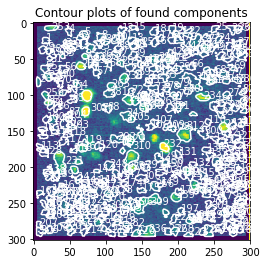

In [14]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
plt.figure(); crd = plot_contours(cnm.A, Cn, thr=0.9)
plt.title('Contour plots of found components')

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [15]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = False, 
                                     thresh_cnn_lowest = cnn_thr)

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


Plot contours of selected and rejected components

/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


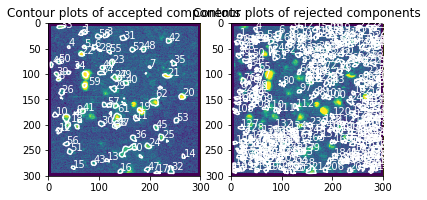

In [16]:
#%% PLOT COMPONENTS

plt.figure();
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(cnm.A[:,idx_components], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(cnm.A[:,idx_components_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [17]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons =Cn,
                denoised_color = 'red');

#np.set_printoptions(threshold=np.nan)




           1           2           3           4           5           6    \
1    28.529146   79.814002   41.640622   39.029182   11.450381   19.319434   
2    69.708739   58.918707   76.692386  119.269881   75.414540   79.076036   
3     0.000000    0.000000    7.019380    0.000000   12.293692    7.676114   
4    59.751545   42.874707   46.040913   61.454059   58.776602   13.759386   
5    30.915276   60.410015   22.508633   13.564169   31.143190   20.821998   
6     8.617618   10.085592    0.000000    0.000000   27.653956    0.000000   
7    27.006504   17.810789   28.642570    0.000000    2.540193    0.000000   
8     0.000000   29.231423    5.834204   43.858800   41.203125    4.299175   
9    31.303643   30.045865   41.792091   15.321802   22.970402   26.590656   
10    6.754435    0.000000   14.023087   10.966072    0.000000    5.355077   
11    0.000000    0.000000    0.000000   27.876348   10.915752   26.570695   
12    0.681158    5.197151    0.000000   10.521599    0.000000  

In [18]:
# rejected components
if len(idx_components_bad) > 0:
    nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                    cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons =Cn,
                    denoised_color = 'red');
else:
    print("No components were rejected.")

           1          2          3          4          5           6    \
1    16.750722  24.837880  26.153320   0.000000  21.380605   10.283063   
2     0.000000   4.493661   0.000000   0.000000   0.000000   22.148470   
3    38.291898   0.056855   5.665437   0.000000   1.336210    8.257058   
4    35.181612  31.782247  26.895871  29.785963  31.158341   17.105676   
5    23.965256  30.375836   7.649447   6.485305  31.947393   19.663202   
6    19.221417   7.692793  32.889581  36.288800  14.498420   16.584145   
7     0.000000  29.427403  17.672264  15.020823  19.094887   31.339654   
8    19.784924  50.889187  61.448389   3.651542   0.000000   25.267521   
9     6.261252   3.541710  15.188795  32.441909  22.105738   27.405269   
10    7.983536  26.290097  28.388739  57.629594  74.162289   69.190359   
11   29.937837  37.104294  14.003401   0.000000   0.000000   20.460227   
12    0.198241  24.816507   7.218404  21.566003  12.942051   13.753972   
13   27.915780   6.077161  23.535979  

## Re-run (seeded) CNMF  on the full Field of View  

In [19]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
A_in, C_in, b_in, f_in = cnm.A[:,idx_components], cnm.C[idx_components], cnm.b, cnm.f
cnm2 = cnmf.CNMF(n_processes=1, k=A_in.shape[-1], gSig=gSig, p=p, dview=dview,
                merge_thresh=merge_thresh,  Ain=A_in, Cin=C_in, b_in = b_in,
                f_in=f_in, rf = None, stride = None, gnb = gnb, 
                method_deconvolution='oasis', check_nan = True)

cnm2 = cnm2.fit(images)

### Extract DF/F values

In [20]:
#%% Extract DF/F values

F_dff = detrend_df_f(cnm2.A, cnm2.b, cnm2.C, cnm2.f, YrA = cnm2.YrA, 
                      quantileMin=8, frames_window=250)



         1         2         3         4         5         6         7    \
1   0.185205  0.510291  0.283625  0.325500  0.118628  0.146841  0.316623   
2   0.316153  0.219214  0.403561  0.675267  0.454381  0.361626  0.303823   
3  -0.081135  0.033829  0.076435 -0.076602 -0.024384  0.000163  0.089956   
4   0.444257  0.160183  0.390206  0.386908  0.435265 -0.046584  0.598786   
5   0.131199  0.373166  0.120430  0.045081  0.155297  0.108841  0.097970   
6  -0.054211 -0.026812 -0.200115 -0.227877 -0.049163 -0.225805  0.054787   
7   0.040396 -0.060940 -0.045754 -0.169300 -0.256433 -0.187222  0.046310   
8  -0.072041  0.214224  0.023986  0.336994  0.374343  0.045979 -0.122649   
9   0.342665  0.280938  0.493602  0.204162  0.199138  0.329414  0.394516   
10 -0.030972 -0.293640  0.142178  0.431969 -0.203819 -0.084322 -0.010567   
11 -0.117897 -0.146214  0.008388  0.169019  0.060478  0.163794  0.048878   
12 -0.206371  0.193062 -0.073887  0.100642  0.097683  0.066140  0.019275   
13 -0.086098

## Display final results

In [21]:
discard_traces_fluo=nb_view_patches(Yr,cnm2.A, cnm2.C, cnm2.b, cnm2.f,
                                    dims[0], dims[1], thr = 0.8, image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

#from bokeh.plotting import figure
#from bokeh.io import show
#plt.figure();

#plt.imshow(np.reshape(cnm2.A[:,5-1].toarray(), dims, order='F'))

#plt.figure()

#plt.plot(F_dff[5-1][1:100])


           1           2           3           4           5           6    \
1    32.946297   64.722492   57.673212   51.489609   46.065378   41.307262   
2    43.681494   42.098165   51.822876   49.723706   47.757542   45.915957   
3    18.896984   18.896984   18.896984   18.896984   18.896984   18.896984   
4    28.277187   27.066420   29.018799   27.741511   26.578792   25.520370   
5    14.531727   14.531727   14.531727   14.531727   14.531727   14.531727   
6    21.144401   21.144401   21.144401   21.144401   21.144401   21.144401   
7    15.132587   15.132587   15.132587   15.132587   15.132587   15.132587   
8     3.242325    7.089301    6.751089    6.442611    6.161253    5.904632   
9    27.877176   27.019860   27.482209   26.642509   25.840261   26.328672   
10    5.273461    5.273461    5.459021    5.422460    5.393103    5.369530   
11   13.320303   13.320303   13.320303   13.320303   13.320303   13.320303   
12    7.545750    7.545750    7.545750    7.545750    7.545750  

you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


<h1> closing, saving, and creating denoised version </h1>

In [22]:
save_results = False
if save_results:
    np.savez(os.path.join(os.path.split(fname_new)[0], 
                          os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
             Cn=Cn, A=cnm2.A.todense(), C=cnm2.C,
             b=cnm2.b, f=cnm2.f, YrA=cnm2.YrA, sn=sn, d1=d1, d2=d2,
             idx_components=idx_components, idx_components_bad=idx_components_bad)

## stop cluster and clean up LOG files

In [23]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

We can inspect the denoised results by reconstructing the movie and playing alongside the original

In [24]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.A.dot(cnm2.C) + \
                    cnm2.b.dot(cnm2.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

reshaping along z
reshaping along z


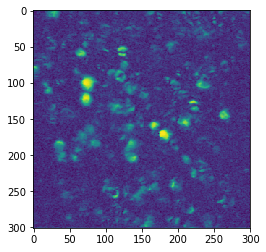

In [28]:
#%% play along side original data
cm.concatenate([m_els.resize(1, 1, downsample_ratio),
                denoised.resize(1, 1, downsample_ratio)], 
                axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit
c_img = m_orig.local_correlations(eight_neighbours = True, swap_dim = False) #correlation image
pl.imshow(c_img)